In [1]:
import pandas as pd
import FINE as fn
import os

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
def dsm_test_esM():
    """
    Generate a simple energy system model with one node, two fixed generators and one load time series
    for testing demand side management functionality.
    """
    # load without dsm
    now = pd.Timestamp.now().round('h')
    number_of_time_steps = 28
    #t_index = pd.date_range(now, now + pd.DateOffset(hours=number_of_timeSteps - 1), freq='h')
    t_index = range(number_of_time_steps)
    load_without_dsm = pd.Series([80.] * number_of_time_steps, index=t_index)

    timestep_up = 10
    timestep_down = 20
    load_without_dsm[timestep_up:timestep_down] += 40.

    time_shift = 3
    cheap_capacity = 100.
    expensive_capacity = 20.

    # set up energy model
    esM = fn.EnergySystemModel(locations={'location'},
                               commodities={'electricity'},
                               numberOfTimeSteps=number_of_time_steps,
                               commodityUnitsDict={'electricity': r'MW$_{el}$'},
                               hoursPerTimeStep=1, costUnit='1 Euro',
                               lengthUnit='km',
                               verboseLogLevel=2)
    esM.add(fn.Source(esM=esM, name='cheap', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(cheap_capacity, index=t_index), opexPerOperation=25))
    esM.add(fn.Source(esM=esM, name='expensive', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(expensive_capacity, index=t_index), opexPerOperation=50))
    esM.add(fn.Source(esM=esM, name='back-up', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(1000, index=t_index), opexPerOperation=1000))

    return esM, load_without_dsm, timestep_up, timestep_down, time_shift, cheap_capacity


In [3]:
dsm_test_esM_ = dsm_test_esM()

In [4]:
"""
Given a one-node system with two generators, check whether the load and generation is shifted correctly in both
directions with and without demand side management.
"""

esM_without, load_without_dsm, timestep_up, timestep_down, time_shift, cheap_capacity = dsm_test_esM_

esM_without.add(fn.Sink(esM=esM_without, name='load', commodity='electricity',
                        hasCapacityVariable=False, operationRateFix=load_without_dsm))

esM_without.optimize(timeSeriesAggregation=False, solver='glpk')  # without dsm

generator_outputs = esM_without.componentModelingDict['SourceSinkModel'].operationVariablesOptimum

# benchmark generation without dsm
cheap_without_dsm = load_without_dsm.clip(0, cheap_capacity).copy()
cheap_without_dsm.name = ('cheap', 'location')
expensive_without_dsm = load_without_dsm - cheap_without_dsm
expensive_without_dsm.name = ('expensive', 'location')

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\LARAWE~1\AppData\Local\Temp\tmpib1xhkqk.glpk.raw --wglp
 C:\Users\LARAWE~1\AppData\Local\Temp\tmpgi3qcbgz.glpk.glp --cpxlp C:\Users\LARAWE~1\AppData\Local\Temp\tmpjvlst15m.pyomo.lp
Reading problem data from 'C:\Users\LARAWE~1\AppData\Local\Temp\tmpjvlst15m.pyomo.lp'...
141 rows, 113 columns, 225 non-zeros
852 lines were read
Writing problem data to 'C:\Users\LARAWE~1\AppData\Local\Temp\tmpgi3qcbgz.glpk.glp'...
679 lines were written
GLPK Simplex Optimizer, v4.65
141 rows, 113 columns, 225 non-zeros
Preprocessing...
18 rows, 36 columns, 36 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 18
*     0: obj =   3.150471429e+08 inf =   0.000e+00 (24)
*    12: obj =   2.221285714e+07 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0

In [5]:
print((generator_outputs.loc[('cheap', 'location')] == cheap_without_dsm).all())
print((generator_outputs.loc[('expensive', 'location')] == expensive_without_dsm).all())

True
True


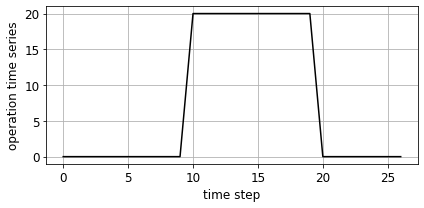

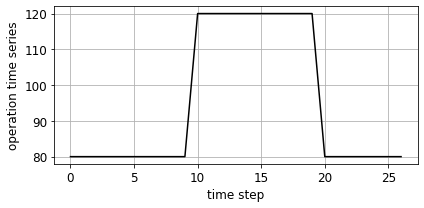

In [6]:
# fig, ax = fn.plotOperation(esM_without,'cheap','location', figsize=(6,3))
fig, ax = fn.plotOperation(esM_without,'expensive','location', figsize=(6,3))
fig, ax = fn.plotOperation(esM_without,'load','location', figsize=(6,3))

In [7]:
def plotShift(tmin, tmax, title, timeSeriesAggregation, esM_with, tBwd, tFwd, shiftMax, numberOfTimeStepsPerPeriod):
    c = esM_with.componentModelingDict['StorageExtModel'].chargeOperationVariablesOptimum

    fig, axT = plt.subplots(1,1,figsize=(9,4))

    axT.plot(np.arange(0.5,tmax-tmin+0.5),
             esM_with.componentModelingDict['DSMModel'].operationVariablesOptimum.\
                 loc[('flexible demand','location'),tmin:tmax-1].values,
            color='k', label='Demand w/- DSM', zorder=10, linestyle = '-')
    axT.set_ylabel('Flexible demand [kW]', fontsize=10)

    axT.set_title(title, fontsize=11)

    if timeSeriesAggregation:
        demand = pd.concat([esM_with.getComponent('flexible demand').aggregatedOperationRateFix.loc[p]
                            for p in esM_with.periodsOrder], ignore_index=True)
        demand = pd.concat([demand.iloc[tBwd:], demand.iloc[:tBwd]]).reset_index(drop=True)
        axT.plot(np.arange(0.5,tmax-tmin+0.5), demand.loc[tmin:tmax-1,'location'].values,
                 color='k',linestyle = '--', label='Demand w/o DSM')            
    else:
        demand = esM_with.getComponent('flexible demand').fullOperationRateFix.loc[0]
        demand = pd.concat([demand.iloc[tBwd:], demand.iloc[:tBwd]]).reset_index(drop=True)
        axT.plot(np.arange(0.5,tmax-tmin+0.5), demand.loc[tmin:tmax-1].values,
                 color='k',linestyle = '--', label='Demand w/o DSM')
    axT.grid(False)

    axT.legend(loc=2, fontsize=9)
    axT.set_xticks(range(0,len(c.T),4))
    axT.set_xlabel('Hour of the day [h]', fontsize=10)

    ax = axT.twinx() 
    
    color_1 = ['blue','grey','red','yellow','green','black','pink']
    marker = ['o','x','*']

    ax.grid(zorder=-10)

    bottom_1 = np.array([0 for i in range(tmax-tmin)])
    bottom_2 = np.array([0 for i in range(tmax-tmin)])

    for x in range(tmax-tmin):
        h = tmin+x
        bottom = 0
        for i in range(tFwd + tBwd + 1):
            if (tBwd + h) % (tFwd + tBwd + 1) == i:
                if timeSeriesAggregation:
                    p = int((h - (h % numberOfTimeStepsPerPeriod))/numberOfTimeStepsPerPeriod)
                    tp = esM_with.periodsOrder[p]
                    h_ = h % numberOfTimeStepsPerPeriod
                    chargeMax = esM_with.getComponent('flexible demand_' + str(i)).\
                        aggregatedChargeOpRateMax.loc[(tp,h_),'location']
                else:
                    chargeMax = esM_with.getComponent('flexible demand_' + str(i)).\
                        fullChargeOpRateMax.loc[(0,h),'location']
                if x == 0:
                    ax.bar([x+0.5], -(chargeMax-c.iloc[i].values[h]), color=color_1[i], zorder=10, 
                           label='Virtual storage_' + str(i), alpha=0.5)
                else:
                    ax.bar([x+0.5], -(chargeMax-c.iloc[i].values[h]), color=color_1[i], zorder=10, alpha=0.5)
            else:
                if x == 0:
                    ax.bar([x+0.5], c.iloc[i].values[h], bottom=[bottom], color=color_1[i], zorder=10,
                           label='Virtual storage_' + str(i), alpha=0.5)
                else:
                    ax.bar([x+0.5], c.iloc[i].values[h], bottom=[bottom], color=color_1[i], zorder=10,
                           alpha=0.5)
                bottom += c.iloc[i].values[h]

    ax.legend(loc=3, fontsize=9)

    ax.set_ylim([-(shiftMax*1.1),(shiftMax*1.1)])
    ax.set_ylabel('Up-/ downshifted demand [kW]', fontsize=10)

    plt.tight_layout()    
    plt.show()

In [8]:
def run_esM_with_DSM(timeSeriesAggregation, numberOfTypicalPeriods = 25,
    numberOfTimeStepsPerPeriod = 1):
    # add DSM
    dsm_test_esM_ = dsm_test_esM()
    tFwd = 3
    tBwd = 3
    esM_with = dsm_test_esM_[0]
    shiftMax = 10

    esM_with.add(fn.DemandSideManagement(esM=esM_with, name='flexible demand', commodity='electricity',
                                         hasCapacityVariable=False, tFwd=tFwd, tBwd=tBwd,
                                         operationRateFix=load_without_dsm, opexShift=1,
                                         shiftDownMax=shiftMax, shiftUpMax=shiftMax,
                                         socOffsetDown=-1, socOffsetUp=-1))

    if timeSeriesAggregation:
        esM_with.cluster(numberOfTimeStepsPerPeriod=numberOfTimeStepsPerPeriod,
                         numberOfTypicalPeriods=numberOfTypicalPeriods)
        esM_with.optimize(timeSeriesAggregation=True, solver='gurobi', optimizationSpecs='LogToConsole=0')
    else:
        esM_with.optimize(timeSeriesAggregation=False, solver='gurobi', optimizationSpecs= 'LogToConsole=0')

    generator_outputs = esM_with.componentModelingDict["SourceSinkModel"].operationVariablesOptimum
    esM_load_with_DSM = esM_with.componentModelingDict['DSMModel'].operationVariablesOptimum

    # benchmark generation and load with dsm
    expensive_with_dsm = expensive_without_dsm.copy()
    expensive_with_dsm[timestep_up:timestep_up + time_shift] -= 10
    expensive_with_dsm[timestep_down - time_shift:timestep_down] -= 10
    expensive_with_dsm.name = ('expensive', 'location')

    cheap_with_dsm = cheap_without_dsm.copy()
    cheap_with_dsm[timestep_up - time_shift:timestep_up] += 10
    cheap_with_dsm[timestep_down:timestep_down + time_shift] += 10
    cheap_with_dsm.name = ('cheap', 'location')

    load_with_dsm = load_without_dsm.copy()
    load_with_dsm[timestep_up - time_shift:timestep_up] += 10
    load_with_dsm[timestep_up:timestep_up + time_shift] -= 10
    load_with_dsm[timestep_down - time_shift:timestep_down] -= 10
    load_with_dsm[timestep_down:timestep_down + time_shift] += 10
    load_with_dsm.name = ('flexible demand', 'location')
    
    print((generator_outputs.loc[('cheap', 'location')] == cheap_with_dsm).all())
    print((generator_outputs.loc[('expensive', 'location')] == expensive_with_dsm).all())
    print((esM_load_with_DSM.loc[('flexible demand', 'location')] == load_with_dsm).all())

    fig, ax = fn.plotOperation(esM_with,'cheap','location', figsize=(6,3))
    ax.plot(cheap_with_dsm, color='orange',linestyle='--')
    fig, ax = fn.plotOperation(esM_with,'expensive','location', figsize=(6,3))
    ax.plot(expensive_with_dsm, color='orange',linestyle='--')
    fig, ax = fn.plotOperation(esM_with,'flexible demand','location', figsize=(6,3))
    ax.plot(load_with_dsm, color='orange',linestyle='--')
    ax.plot(load_without_dsm, color='forestgreen',linestyle=':')
    plt.show()
    
    c = esM_with.componentModelingDict['StorageExtModel'].chargeOperationVariablesOptimum
    chargeMax = (pd.concat([esM_with.getComponent('flexible demand_' + str(i)).fullChargeOpRateMax.loc[0]
                            for i in range(tFwd + tBwd + 1)], axis=1, keys=['flexible demand_' + str(i)
                 for i in range(tFwd + tBwd +1)]).T)

    plotShift(0, len(c.T), 'Shift profile', timeSeriesAggregation, esM_with, tBwd, tFwd, shiftMax,
             numberOfTimeStepsPerPeriod)

Using license file C:\Users\LaraWelder\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\LARAWE~1\AppData\Local\Temp\tmpyj16t5qz.pyomo.lp
Reading time = 0.01 seconds
x708: 1016 rows, 708 columns, 2395 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter Threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Parameter logfile unchanged
   Value:   Default: 
True
True
True


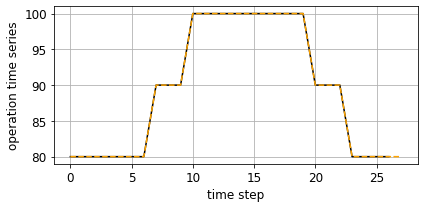

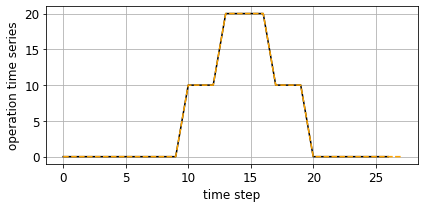

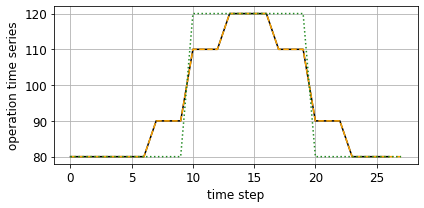

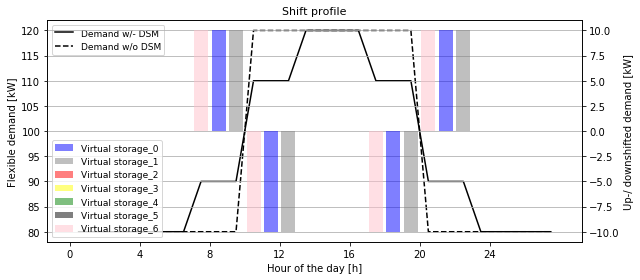

In [9]:
run_esM_with_DSM(False)

Using license file C:\Users\LaraWelder\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\LARAWE~1\AppData\Local\Temp\tmpmo_b4v6t.pyomo.lp
Reading time = 0.00 seconds
x1354: 1496 rows, 1004 columns, 3512 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter Threads to 3
   Prev: 0  Min: 0  Max: 1024  Default: 0
Parameter logfile unchanged
   Value:   Default: 
True
True
True


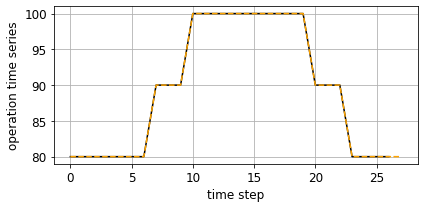

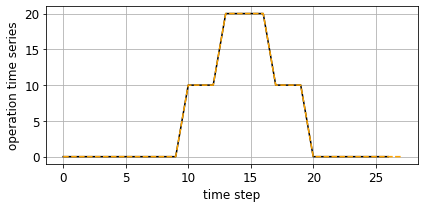

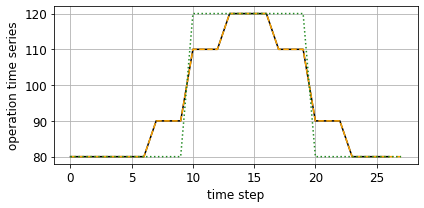

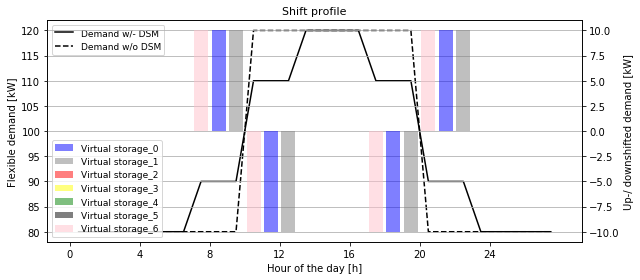

In [10]:
run_esM_with_DSM(True)